In [127]:
import pandas as pd
import numpy as np
import networkx as nx
from itertools import islice

from pyvis.network import Network
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data

In [128]:
# Loading data
hero_network = pd.read_csv('data/hero-network.csv')
edges = pd.read_csv('data/edges.csv')

In [129]:
# Get list of comics
def get_comics_list():
    # Get node type from nodes
    node_types = pd.read_csv('data/nodes.csv')

    # Return unique list of comics
    return node_types.loc[node_types['type'] == 'comic', 'node'].unique().tolist()

# Filter graph by top N heroes
def filter_graph(G, N):

    # Group the data by hero and count the number of appearances
    hero_counts = edges.groupby('hero').count()

    # Sort the data by the number of appearances in descending order
    hero_counts = hero_counts.sort_values('comic', ascending=False)

    # Get the top N heroes
    top_heroes = hero_counts.head(N).index.tolist()

    # Get the neighbors of the top heroes
    neighbors = set()

    for hero in top_heroes:
        neighbors |= set(G.neighbors(hero))

    # Create a subgraph containing only top heroes and their neighbors
    return G.subgraph(top_heroes + list(neighbors))

# Build graph 1
def build_graph_1(df):

    G = nx.Graph() # Initialize graph

    # Keep a dictionary to store the total number of collaborations for each pair of heroes
    num_collaborations = {}

    # Explore all the collaborations for each pair of heroes in the dataset
    for index, row in df.iterrows():

        # Get heroes
        hero_1, hero_2 = row['hero1'], row['hero2']

        # Order current hero pair
        hero_pair = tuple(sorted((hero_1, hero_2)))

        # Increment the total number of collaborations for the pair of heroes
        if hero_pair in num_collaborations:
            num_collaborations[hero_pair] += 1
        else:
            num_collaborations[hero_pair] = 1

    # Build the graph
    for hero_1, hero_2 in num_collaborations.keys():

        # Add heroes to the graph only if they are not already present
        if not G.has_node(hero_1):
            G.add_node(hero_1)

        if not G.add_node(hero_2):
            G.add_node(hero_2)

        # Calculate the inverse of the total number of collaborations between the two heroes
        weight = 1 / num_collaborations[(hero_1, hero_2)]

        # Add an edge between the two heroes, with the calculated weight
        G.add_edge(hero_1, hero_2, weight=weight)

    return G

# Build graph 2
def build_graph_2(df):

    G = nx.Graph() # Initialize graph

    # Explore all the appearances in comics
    for index, row in df.iterrows():

        # Get hero and comic
        hero, comic = row['hero'], row['comic']

        # Add nodes the graph only if they are not already present
        if not G.has_node(hero):
            G.add_node(hero)

        if not G.add_node(comic):
            G.add_node(comic)

        # Add an edge between the two nodes
        G.add_edge(hero, comic)

    return G

# Plot graph
def plot_graph(G):
    plt.figure(figsize=(10,10))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

## Data Preprocessing

In [130]:
# Remove extra space and trailing /s
hero_network["hero1"] = hero_network["hero1"].apply(lambda x: x.strip().rstrip('/'))
hero_network["hero2"] = hero_network["hero2"].apply(lambda x: x.strip().rstrip('/'))
edges["hero"] = edges["hero"].apply(lambda x: x.strip().rstrip('/'))


# Fix Spider-Man name
hero_network.loc[hero_network['hero1'] == 'SPIDER-MAN/PETER PAR', 'hero1'] = 'SPIDER-MAN/PETER PARKER'
hero_network.loc[hero_network['hero2'] == 'SPIDER-MAN/PETER PAR', 'hero2'] = 'SPIDER-MAN/PETER PARKER'

# Remove self-loops
hero_network = hero_network.loc[hero_network['hero1'] != hero_network['hero2'], ['hero1', 'hero2']]

# 2. Backend Implementation

In [131]:
# Functionality 1 - extract the graph's features
def extract_features(G, graph_type, N=None):
    
    # Initialize output variables
    num_nodes = 0
    num_collaborations = {}
    num_heroes_per_comic = {}
    density = 0
    degree_distribution = {}
    average_degree = 0
    hubs = []
    network_type = ""

    # If N is set, filter the data to consider only the top N heroes
    if N is not None:
        G = filter_graph(G, N)

    # Determine the number of nodes in the network
    num_nodes = G.number_of_nodes()

    # Calculate the number of collaborations for each hero (only for graph type 1)
    if graph_type == 1:
        for node in G.nodes():
            num_collaborations[node] = G.degree[node]

    # Calculate the number of heroes that have appeared in each comic (only for graph type 2)
    if graph_type == 2:
        # Extract list of comics
        comics_list = get_comics_list()

        for node in G.nodes():
            if node in comics_list:
                num_heroes_per_comic[node] = G.degree[node]

    # Calculate the density of the network
    density = nx.density(G)

    # Calculate the degree distribution of the network
    degree_sequence = sorted([d for n, d in G.degree()])
    degree_count = nx.degree_histogram(G)

    for degree, count in enumerate(degree_count):
        degree_distribution[degree] = count

    # Calculate the average degree of the network
    average_degree = sum(degree_sequence) / num_nodes

    # Determine the hubs of the network
    degree_percentile = np.percentile(degree_sequence, 95)

    for node, degree in G.degree():
        if degree > degree_percentile:
            hubs.append(node)

    # Determine whether the network is sparse or dense
    if density <= 0.5:
        network_type = "sparse"
    else:
        network_type = "dense"

    # Return the output
    return {
        "num_nodes": num_nodes,
        "num_collaborations": num_collaborations,
        "num_heroes_per_comic": num_heroes_per_comic,
        "density": density,
        "degree_distribution": degree_distribution,
        "average_degree": average_degree,
        "hubs": hubs,
        "network_type": network_type
    }


# Functionality 2 - Find top superheroes!
def find_top_superheroes(G, node, metric, N=None):

    # If N is set, filter the data to consider only the top N heroes
    if N is not None:
        G = filter_graph(G, N)

    # Compute the metric values of the nodes
    if metric == 'betweenness':
        metric_values = nx.betweenness_centrality(G)
    elif metric == 'pagerank':
        metric_values = nx.pagerank(G)
    elif metric == 'closeness':
        metric_values = nx.closeness_centrality(G)
    elif metric == 'degree':
        metric_values = nx.degree_centrality(G)
    else:
        return 'Invalid metric, chose between: betweenness, pagerank, closeness, degree.'

    # Get the value of the given node
    node_value = metric_values[node]

    return metric_values, node_value


# Functionality 3 - The Shortest ordered Route
def shortest_ordered_route(G, h, h_1, h_n, N=None):

    # If N is set, filter the data to consider only the top N heroes
    if N is not None:
        G = filter_graph(G, N)

    # Check if the given sequence is valid for the graph
    for node in h:
        if nx.node_connectivity(G, h_1, node) <= 0:
            return "Error: there is no such path."

    # Get all paths from h_1 to h_n
    paths = nx.all_simple_paths(G, source = h_1, target = h_n)

    # Take only the first N paths
    paths_first_N = islice(paths, len(G.nodes))

    # Convert the generator object to a list
    paths = list(paths_first_N)

    # Initialize list to save only valid paths
    valid_paths = []

    # Check which paths are valid
    if len(h) > 0:
        for path in paths:
            sequence = h
            valid = True

            expected = sequence[0] # Extract from h the node that has to be visited before the others in the list
            sequence = sequence[1:] # Update the sequence

            for node in path:
                # If all nodes from h were visit in order we can exit the inner loop
                if len(sequence) == 0:
                    break

                # When the expected node is visited we must update it and h
                if node == expected:
                    expected = sequence[0]
                    sequence = sequence[1:]

                # If node skips expected the path is not valid
                if node in sequence:
                    valid = False
                    break

            # Append the path to valid path list
            if valid:
                valid_paths.append(path)

        # Sort the paths by length in ascending order
        valid_paths.sort(key=len)
    else:
        valid_paths = paths

    # Return the shortest path
    if len(valid_paths) > 0:
        return valid_paths[0]

    return []


# Functionality 4 - Disconnecting Graphs
def find_min_links_to_disconnect(G, heroA, heroB, N=None):

    # If N is set, filter the data to consider only the top N heroes
    if N is not None:
        G = filter_graph(G, N)

    # Find the shortest path between heroA and heroB
    try:
        path = nx.shortest_path(G, heroA, heroB)
    except nx.NetworkXNoPath:
        return "Error: there is no path between the two heroes."

    # Return the minimum number of links required to disconnect the graph
    return len(path) - 1


# Functionality 5 - Extracting Communities
def extract_communities(G, hero1, hero2, N=None):

    # If N is set, filter the data to consider only the top N heroes
    if N is not None:
        G = filter_graph(G, N)

    # Create a copy of the graph
    G_copy = G.copy()

    # Initialize community list
    communities = {node: node for node in G_copy.nodes()}

    # Initialize the minimum number of edges to be removed
    min_edges_removed = 0

    # Find the shortest path between hero1 and hero2
    try:
        shortest_path = nx.shortest_path(G_copy, source=hero1, target=hero2)
    except nx.NetworkXNoPath:
        shortest_path = []

    # If there is no path between hero1 and hero2, return the empty list of communities
    if len(shortest_path) < 1:
        return 0, [], False

    # Iterate over the edges that must be removed
    for i in range(1, len(shortest_path)):
        # Remove the edge between the current node and the next node in the shortest path
        G_copy.remove_edge(shortest_path[i - 1], shortest_path[i])

        # Find the connected components in the graph
        connected_components = [list(component) for component in nx.connected_components(G_copy)]

        # Check if hero1 and hero2 belong to the same connected component
        same_component = False
        for component in connected_components:
            if hero1 in component and hero2 in component:
                same_component = True
                break

        # If hero1 and hero2 do not belong to the same connected component, update the minimum number of edges to be removed and the list of communities
        if not same_component:
            min_edges_removed = i
            communities = {node: i for i, component in enumerate(connected_components) for node in component}

    return min_edges_removed, communities, same_component

**Explanation of the 4 centrality measures used in functionality 2**

**Betweenness centrality**: This measure reflects how many times a node lies on the shortest path between two other nodes. If a node has a high betweenness value, it means that it is important for connecting other nodes acting like a bridge.

**PageRank**: This measure reflects the importance of a node in the network based on the number and importance of the nodes that link to it. If a node has a high PageRank value, it means that it is well-connected.

**Closeness centrality**: This measure reflects how close a node is to all other nodes in the network. A node with high closeness centrality is able to reach other nodes quickly and is therefore important for the flow of information within the network.

**Degree centrality**: This measure reflects the number of neighbors a node has. A node with high degree centrality is well-connected and has many neighbors.

**Example**
What if the betweenness is low but the node still has a high PageRank value?
If a node has a low betweenness but high PageRank, it may still be an important and influential node for the graph: its importance and influence may be more localized within its own community rather than in terms of connecting other groups or communities in the graph.

# 3. Frontend Implementation

In [132]:
G = build_graph_2(edges)

In [133]:
# Visualization 1 - Visualize some features of the network
def visualize_features(G, graph_type, N=None):

    # Extract features from the graph
    extracted_features = extract_features(G, graph_type, N)

    num_nodes = extracted_features['num_nodes']
    density = extracted_features['density']
    avg_degree = extracted_features['average_degree']
    hubs = extracted_features['hubs']
    degree_distribution =extracted_features['degree_distribution']
    sparse_or_dense =extracted_features['network_type']

    # Print the general information about the graph
    print(f'Number of nodes in the network: {num_nodes}')
    print(f'Density of the network: {density}')
    print(f'Average degree of the network: {avg_degree}')
    print(f'Network is {sparse_or_dense}')

    # Print the table of network hubs
    print('Network hubs:')
    print('Node')
    for hub in hubs:
        print(f'{hub}\t')

    # Plot the number of collaborations of each hero in descending order (if the graph is type 1)
    if graph_type == 1:
        # Get a reverse ordered list of tuples with each hero and its number of collaborations
        heroes_collabs = [(node, G.degree(node)) for node in G.nodes()]
        heroes_collabs.sort(key=lambda x: x[1], reverse=True)

        # Split into two lists
        heroes, collabs = zip(*heroes_collabs)

        # Plot
        plt.bar(heroes, collabs)
        plt.xlabel('Heroes')
        plt.ylabel('Number of collaborations')
        plt.title('Number of collaborations of each hero')
        plt.show()

    # Plot the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)
    if graph_type == 2:
         # Get a reverse ordered list of tuples with each comic and its number heroes who appeared in it
        comics_appearances = [(node, G.degree(node)) for node in G if node in get_comics_list()]
        comics_appearances.sort(key=lambda x: x[1], reverse=True)

        # Split into two lists
        comics, appearances = zip(*comics_appearances)

        # Plot the degrees
        plt.bar(comics, appearances)
        plt.xlabel('Comics')
        plt.ylabel('Number of heroes')
        plt.title('Number of heroes who appeared in each comic')
        plt.show()

    # Plot the degree distribution of the network
    plt.hist(degree_distribution, bins=50)
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title('Degree distribution of the network')
    plt.show()

Number of nodes in the network: 6059
Density of the network: 0.0005522889779063159
Average degree of the network: 3.3457666281564613
Network is sparse
Network hubs:
Node
FF 22	
M/GN 1	
IW 1	
FF 166	
T '99	
FF3 36	
DAZZ 21	
SS3 14	
AF 111	
M/TIO 75	
CA3 7	
ASM 3	
ASM 16	
FF 306	
FF 35	
THING/BENJAMIN J. GR	
M/SHSW 3	
IM3 35	
IG 4	
A 233	
A 327	
COC 3	
FF 341	
UX 336	
A 305	
IW 4	
ASM 1/2	
FF 167	
FFV.X 1	
A 18/2	
IM3 14	
FF 367	
WOSM 76	
A 25	
FF 347	
M/SHSW 9	
SENTRY 2	
A 21	
DF 4.7	
FFV.X 2	
A3 1	
A 221	
FF '01	
FF3 27	
X 55	
MAXSEC 2	
A 128	
M/TE 13	
H2 123	
SPIDER-MAN/PETER PARKER	
FF 369	
FF 1/2	
M/TIO 69	
FF3 28	
DF 3.6	
A 14	
UX 167	
UX 14	
DAMCON3 4	
FF 57	
FF 14	
ASM 18	
FF3 7	
FF2 3	
FF3 40	
ASM2 4	
FF 31	
FF 416	
GAL 3	
FF3 15	
WOLVERINE/LOGAN	
MARVELS 3	
M/SHSW 7	
A 3	
UTSM '96	
FF 36	
MK3 41	
T 14	
M/TIO 27	
SENSM 28	
M/SHSW 2	
IW 5	
A 13	
WOSM 5	
ST 156	
PM&IF 125	
HUMAN TORCH/JOHNNY S	
M/TIO 46	
WM2 13	
FF 349	
H2 321	
FF 112	
FF 256	
ASM2 1	
M/SHSW 12	
WIW 8	
H2 153	
FF 

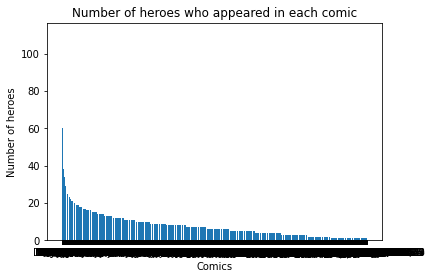

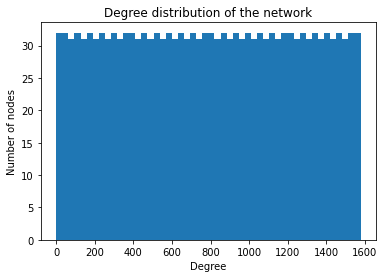

In [134]:
visualize_features(G, 2, N = 10)

In [135]:
# Visualization 2 - Visualize centrality measure
def visualize_centrality_measure(G, node, metric, N=None):

    # Find the top superheroes based on the given metric
    metric_values, node_value = find_top_superheroes(G, node, metric, N)

    # Calculate the average value of the metric over all nodes
    average_value = sum(metric_values.values()) / len(metric_values)

    # Print the results
    print(f'Average value of {metric}: {average_value}')
    print(f'{metric} value for {node}: {node_value}')

In [136]:
visualize_centrality_measure(G, 'CAPTAIN AMERICA', 'degree', N = 100)

Average value of degree: 0.0005522889779062489
degree value for CAPTAIN AMERICA: 0.22020468801584683


In [137]:
# Visualization 3 - Visualize the shortest-ordered route
def visualize_shortest_route(G, h, h_1, h_n, N=None):

    # Get the shortest path
    shortest_path = shortest_ordered_route(G, h, h_1, h_n, N)

    print('Comics in the shortest walk:')
    [print(node) for node in shortest_path if node in get_comics_list()]

    # Plot the shortest path nodes
    plot_graph(G.subgraph(shortest_path))

Comics in the shortest walk:
A '00


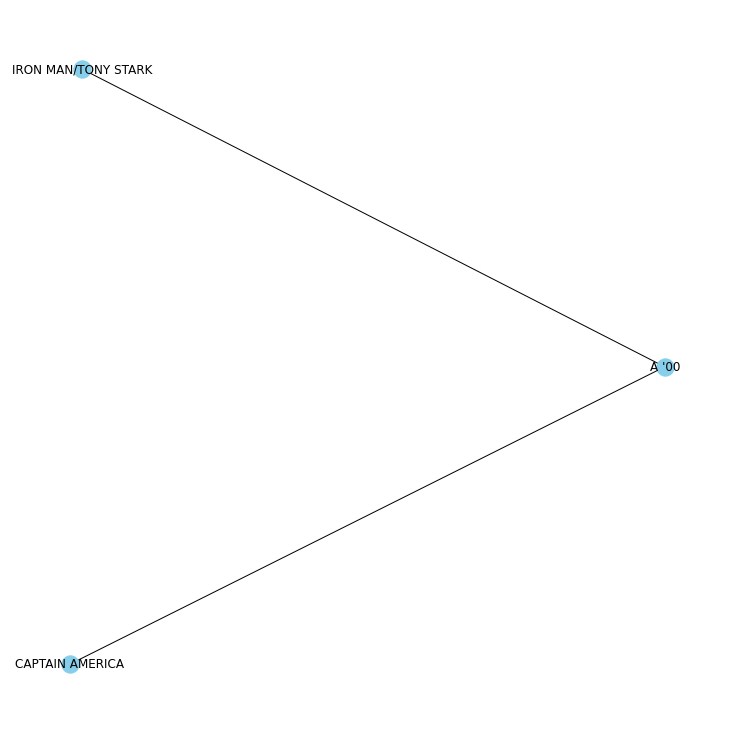

In [138]:
visualize_shortest_route(G, ["A '00"], 'IRON MAN/TONY STARK', 'CAPTAIN AMERICA', N = 100)

In [139]:
# Visualization 4 - Visualize the disconnected graph
def visualize_disconnected_graph(G, heroA, heroB, N=None):

    # Find the minimum number of links required to disconnect the graph
    min_links = find_min_links_to_disconnect(G, heroA, heroB, N)

    # Retrieve the path
    path = nx.shortest_path(G, heroA, heroB)

    # Create a copy of the original graph
    G_disconnected = G.copy()

    # Remove the links in the shortest path from the copy of the graph
    for i in range(min_links):
        G_disconnected.remove_edge(path[i], path[i+1])

    # Plot the original graph
    plt.figure()
    plot_graph(G)
    plt.title('Original graph')

    # Plot the disconnected graph
    plt.figure()
    plot_graph(G_disconnected)
    plt.title(f'Disconnected graph (removed {min_links} links)')

In [ ]:
visualize_disconnected_graph(G, 'IRON MAN/TONY STARK', 'CAPTAIN AMERICA', N = 10)

In [ ]:
G = build_graph_2(hero_network)

In [ ]:
# Visualization 5 - Visualize the communities
def visualize_communities(G, hero1, hero2, N=None):

    # Extract communities and related info
    min_edges_removed, communities, same_component = extract_communities(G, hero1, hero2, N)

    print(f"Number of links that should be removed: {min_edges_removed}")

    # Table depicting the communities and the heroes that belong to each community
    print("Communities:")
    for i, community in enumerate(communities):
        print(f"Community {i}:", community)

    # Plot the original graph
    plt.figure()
    plot_graph(G)
    plt.title("Original graph")

    # Plot the graph showing the communities in the network
    plt.figure()
    color_map = []
    for node in G:
        for i, community in enumerate(communities):
            if node in community:
                color_map.append(i)
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.title("Graph showing communities")

    # Plot the final graph and identify the community/communities of Hero_1 and Hero_2
    plt.figure()
    color_map = []
    for node in G:
        if node == hero1 or node == hero2:
            color_map.append('r')
        else:
            for i, community in enumerate(communities):
                if node in community:
                    color_map.append(i)
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.title("Final graph showing community of Hero 1 and Hero 2")

In [ ]:
visualize_communities(G, 'IRON MAN/TONY STARK', 'CAPTAIN AMERICA', N=100)